In [ ]:
import tensorflow as tf
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Size = 256
num_images = 800

In [ ]:
#Read Images
image_names = glob.glob('/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/*.jpg')
print (image_names)
image_names.sort()
print (image_names)
image_names_subset = image_names[0:num_images]

# Read rgb images
images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in image_names_subset]

# Convert the list of images to a NumPy array
image_dataset = np.array(images)

['/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/100566.jpg', '/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/100567.jpg', '/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/100568.jpg', '/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/100569.jpg', '/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/100570.jpg', '/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/100571.jpg', '/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/100572.jpg', '/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/100573.jpg', '/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/100574.jpg', '/content/drive/MyDrive/CS_Project/R

In [ ]:
#Read Masks
mask_names = glob.glob('/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Masks/*.png')
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask,0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [ ]:
print ("Image data shape is: ", image_dataset.shape)
print ("Mask data shape is: ", mask_dataset.shape)
print ("Max pixel value in image is: ", image_dataset.max())
print ("Labels in the mask are: ", np.unique(mask_dataset))

Image data shape is:  (800, 256, 256, 3)
Mask data shape is:  (800, 256, 256, 1)
Max pixel value in image is:  255
Labels in the mask are:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 

In [ ]:
image_dataset = image_dataset /255.
mask_dataset = mask_dataset /255.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(image_dataset, mask_dataset, test_size=0.2, random_state=42)


In [ ]:
import random

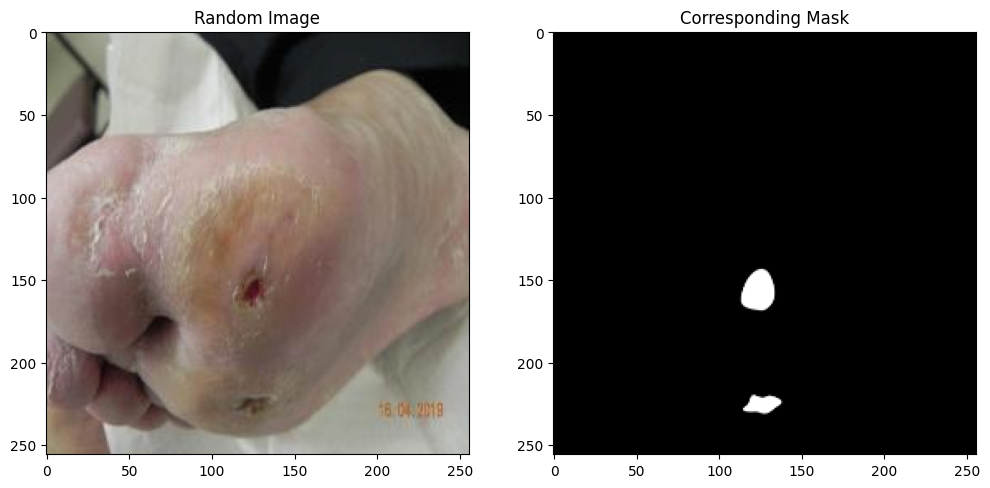

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_random_image_with_mask(images, masks):
    # Generate a random index
    random_index = random.randint(0, len(images) - 1)

    # Get the random image and mask
    random_image = images[random_index]
    random_mask = masks[random_index]

    # Plot the random image and mask
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.imshow(random_image)
    plt.title("Random Image")

    plt.subplot(122)
    plt.imshow(random_mask, cmap='gray')
    plt.title("Corresponding Mask")

    plt.show()

# Call the function to plot a random RGB image with its RGB mask
plot_random_image_with_mask(X_train, Y_train)

In [ ]:
print ("Image data shape is: ", image_dataset.shape)
print ("Mask data shape is: ", mask_dataset.shape)

Image data shape is:  (800, 256, 256, 3)
Mask data shape is:  (800, 256, 256, 1)


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

import tensorflow as tf
from tensorflow.keras import layers

def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(256, 256, 3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs with 1 channel for masks
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)

    # U-Net model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model


In [ ]:
model = build_unet_model()


In [ ]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
from keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model using the 'fit' method
history = model.fit(X_train, Y_train,
                    batch_size=10,
                    epochs=100,
                    validation_data=(X_test, Y_test),
                    shuffle=False)

Epoch 1/100
64/64 [==============================] - 83s 779ms/step - loss: 0.1566 - accuracy: 0.9592 - val_loss: 0.1333 - val_accuracy: 0.9673
Epoch 2/100
64/64 [==============================] - 51s 798ms/step - loss: 0.1294 - accuracy: 0.9650 - val_loss: 0.1253 - val_accuracy: 0.9673
Epoch 3/100
64/64 [==============================] - 50s 786ms/step - loss: 0.1242 - accuracy: 0.9650 - val_loss: 0.1189 - val_accuracy: 0.9673
Epoch 4/100
64/64 [==============================] - 49s 758ms/step - loss: 0.1195 - accuracy: 0.9650 - val_loss: 0.1143 - val_accuracy: 0.9673
Epoch 5/100
64/64 [==============================] - 48s 754ms/step - loss: 0.1135 - accuracy: 0.9650 - val_loss: 0.1052 - val_accuracy: 0.9675
Epoch 6/100
64/64 [==============================] - 48s 756ms/step - loss: 0.1049 - accuracy: 0.9652 - val_loss: 0.1052 - val_accuracy: 0.9679
Epoch 7/100
64/64 [==============================] - 48s 756ms/step - loss: 0.0923 - accuracy: 0.9659 - val_loss: 0.0814 - val_accuracy:

In [ ]:
model.save ('/content/drive/MyDrive/AZH wound care center dataset/Segmentation_model4')


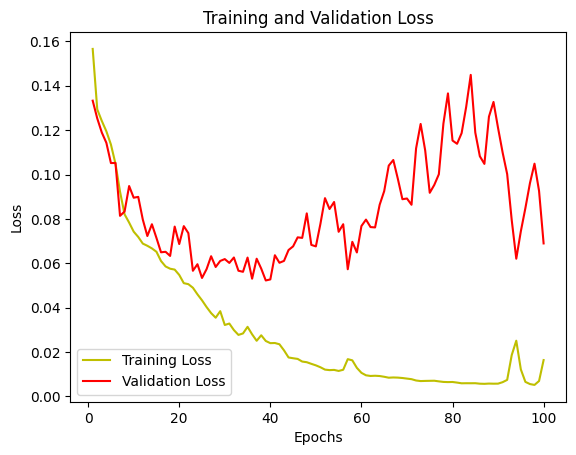

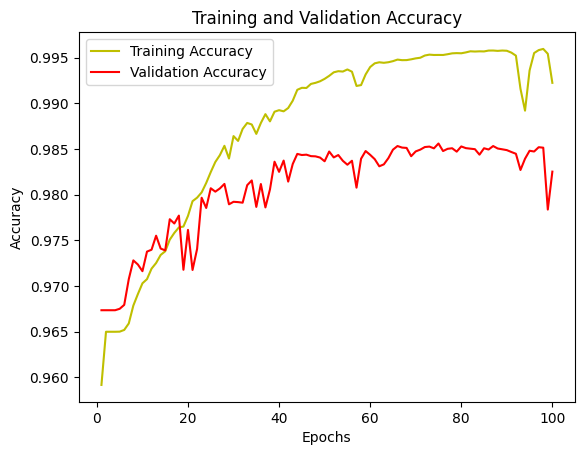

In [ ]:
#plot the training and validation accuracy and loss at each epoch
# Plot training and validation loss
loss= history.history['loss']
val_loss = history.history['val_loss']
epochs = range (1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc , 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Segmentation Dataset/Model/model_for_segmentation4.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#load saved model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Segmentation Dataset/Model/model_for_segmentation4.h5')

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

threshold = 200
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = Y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
print (test_img_input.shape)

prediction = model.predict(test_img_input)[0, :, :, 0]
prediction_thresholded = (prediction > threshold).astype(np.uint8)
print(prediction.shape)

# Visualize the images
plt.figure(figsize=(16,8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img [:,:,0], cmap ='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth [:,:,0], cmap ='gray')
plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(prediction, cmap='gray')

plt.show()


1/1 [==============================] - 0s 38ms/step


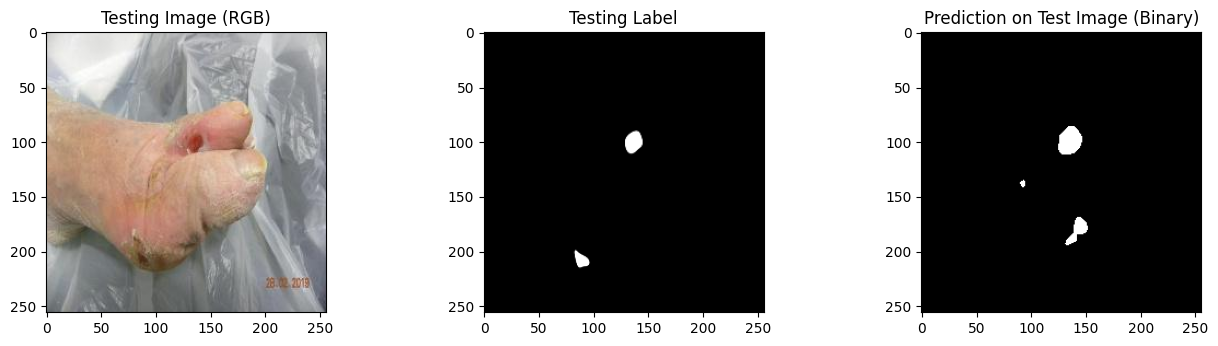

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Set the threshold for binary conversion
threshold = 0.2 # Adjust the threshold as needed

# Randomly select a test image
test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]

# Expand dimensions for model input
test_img_input = np.expand_dims(test_img, axis=0)

# Predict the mask using the model
prediction = model.predict(test_img_input)[0, :, :, 0]

# Convert the prediction to a binary mask using the threshold
prediction_binary = (prediction > threshold).astype(np.uint8)

# Visualize the images
plt.figure(figsize=(16, 8))

# Original testing image (RGB)
plt.subplot(231)
plt.title('Testing Image (RGB)')
plt.imshow(test_img)

# Ground truth label (as grayscale)
ground_truth = Y_test[test_img_number]
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:, :, 0], cmap='gray')

# Prediction on test image (binary)
plt.subplot(233)
plt.title('Prediction on Test Image (Binary)')
plt.imshow(prediction_binary, cmap='gray')

plt.show()


In [ ]:
import cv2
import numpy as np

def calculate_iou(mask, generated_mask):
    # Convert the mask and generated_mask to binary format (0 or 255)
    mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)[1]
    generated_mask = cv2.threshold(generated_mask, 1, 255, cv2.THRESH_BINARY)[1]

    # Compute the intersection and union of the binary masks
    intersection = np.logical_and(mask, generated_mask)
    union = np.logical_or(mask, generated_mask)

    # Calculate the IoU (Jaccard Similarity) score
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Load your mask and generated_mask images here
mask = cv2.imread('/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Masks/100001.png', cv2.IMREAD_GRAYSCALE)
generated_mask = cv2.imread('/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Masks/100001.png', cv2.IMREAD_GRAYSCALE)

# Calculate the IoU score
iou_score = calculate_iou(mask, generated_mask)

print(f"Jaccard Similarity (IoU) Score: {iou_score:.4f}")


Jaccard Similarity (IoU) Score: 1.0000


1/1 [==============================] - 0s 280ms/step


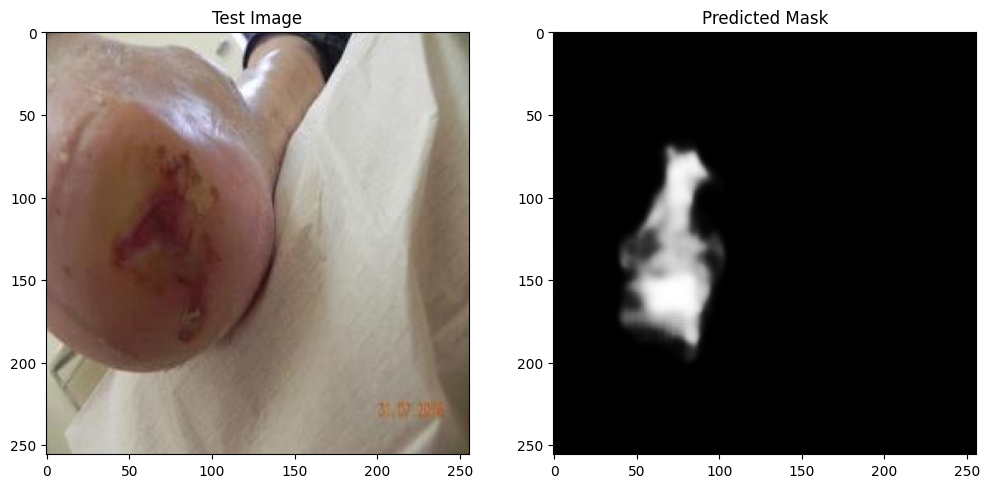

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import os

# Load the trained model
model = load_model('/content/drive/MyDrive/Segmentation Dataset/Model/model_for_segmentation4.h5')

# Specify the image path
image_path = '/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/100829.jpg'
# Check if the image file exists
if not os.path.isfile(image_path):
    print(f"Error: The image file '{image_path}' does not exist.")
else:
    try:
        # Read the test image
        test_image = cv2.imread(image_path)

        if test_image is None:
            print(f"Error: OpenCV failed to read the image file '{image_path}'.")
        else:
            # Convert the image to RGB format
            test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

            # Preprocess the test image in the same way as training images
            test_image = cv2.resize(test_image, (256, 256))
            test_image = test_image / 255.0  # Normalize the image

            # Make predictions using your model
            test_image_input = np.expand_dims(test_image, axis=0)
            predictions = model.predict(test_image_input)

            # Visualize the test image and the predicted segmentation mask
            plt.figure(figsize=(12, 6))

            # Original test image
            plt.subplot(121)
            plt.imshow(test_image)
            plt.title("Test Image")

            # Predicted segmentation mask (no threshold)
            plt.subplot(122)
            plt.imshow(predictions[0, :, :, 0], cmap='gray')
            plt.title("Predicted Mask")

            plt.show()

    except Exception as e:
        print(f"Error: {str(e)}")


1/1 [==============================] - 0s 278ms/step


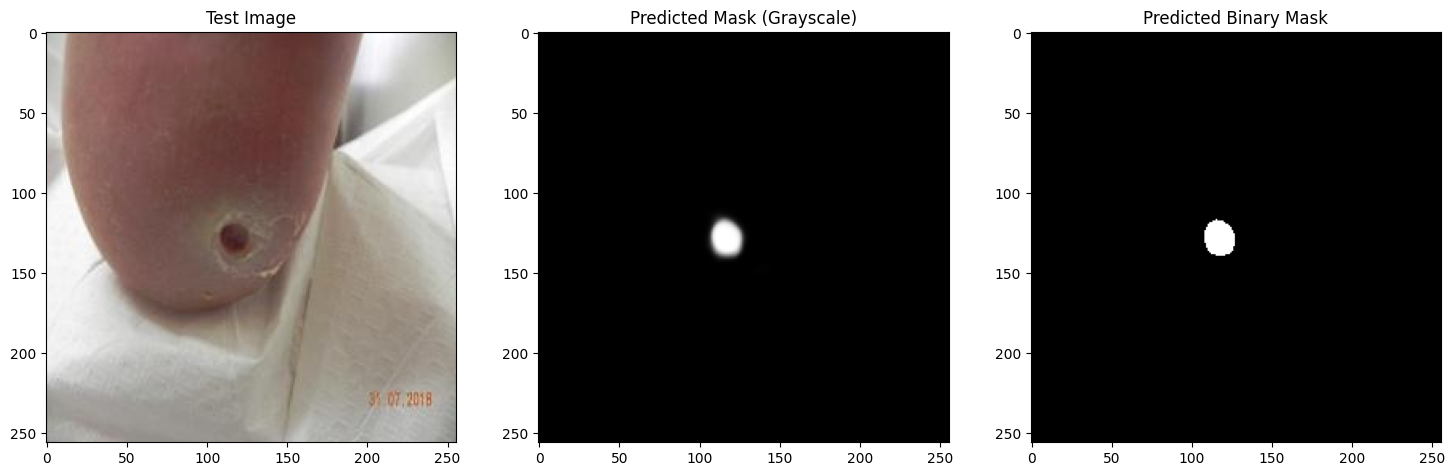

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import os

# Load the trained model
model = load_model('/content/drive/MyDrive/Segmentation Dataset/Model/model_for_segmentation4.h5')

# Specify the image path
image_path = '/content/drive/MyDrive/CS_Project/Resized_Segmentation_Dataset/Dataset_final/Numbered_images/100831.jpg'

# Check if the image file exists
if not os.path.isfile(image_path):
    print(f"Error: The image file '{image_path}' does not exist.")
else:
    try:
        # Read the test image
        test_image = cv2.imread(image_path)

        if test_image is None:
            print(f"Error: OpenCV failed to read the image file '{image_path}'.")
        else:
            # Convert the image to RGB format
            test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

            # Preprocess the test image in the same way as training images
            test_image = cv2.resize(test_image, (256, 256))
            test_image = test_image / 255.0  # Normalize the image

            # Make predictions using your model
            test_image_input = np.expand_dims(test_image, axis=0)
            predictions = model.predict(test_image_input)

            # Threshold the predicted mask to create a binary image
            binary_mask = (predictions[0, :, :, 0] > 0.5).astype(np.uint8)

            # Visualize the test image, predicted mask, and binary mask
            plt.figure(figsize=(18, 6))

            # Original test image
            plt.subplot(131)
            plt.imshow(test_image)
            plt.title("Test Image")

            # Predicted segmentation mask (grayscale)
            plt.subplot(132)
            plt.imshow(predictions[0, :, :, 0], cmap='gray')
            plt.title("Predicted Mask (Grayscale)")

            # Binary mask
            plt.subplot(133)
            plt.imshow(binary_mask, cmap='gray')
            plt.title("Predicted Binary Mask")

            plt.show()

    except Exception as e:
        print(f"Error: {str(e)}")
